## Defining the `Dataset`
> Inspired from torchvision tutorial on object detection [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [1]:
import os 
import numpy as np 
import torch 
from PIL import Image
import pandas as pd
import ast

In [2]:
class WheatDataset(object):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms 
        self.train_csv = pd.read_csv(os.path.join(root, "train.csv"))
        self.train_csv['bbox'] = self.train_csv.bbox.apply(self.get_list)
        self.img_ids = self.train_csv.image_id.unique()
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'train', f"{self.img_ids[idx]}.jpg")
        img = Image.open(img_path).convert("RGB")
        boxes = list(self.train_csv.query(f"image_id=='{self.img_ids[idx]}'").bbox)
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.dim()==1: 
            boxes = boxes.unsqueeze(0)
            print(boxes.shape)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["image_id"] = self.imgs[idx].strip('.jpg')
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None: img, target = self.transforms(img, target)
        return img, target

    def __len__(self): return len(self.img_ids)
    
    def get_list(self, o): return list(map(float, o.strip('][').split(',')))

In [4]:
trn_dataset = WheatDataset("/home/ubuntu/repos/kaggle/wheat/data")
trn_dataset[0]

(<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F7F761489E8>,
 {'boxes': tensor([[ 834.,  222.,  890.,  258.],
          [ 226.,  548.,  356.,  606.],
          [ 377.,  504.,  451.,  664.],
          [ 834.,   95.,  943.,  202.],
          [  26.,  144.,  150.,  261.],
          [ 569.,  382.,  688.,  493.],
          [  52.,  602.,  134.,  647.],
          [ 627.,  302.,  749.,  377.],
          [ 412.,  367.,  480.,  449.],
          [ 953.,  220., 1009.,  323.],
          [  30.,   70.,  156.,  203.],
          [  35.,  541.,   81.,  587.],
          [ 103.,   60.,  220.,  143.],
          [ 417.,    4.,  527.,   95.],
          [ 764.,  299.,  883.,  392.],
          [ 539.,   58.,  597.,  188.],
          [ 139.,  274.,  260.,  350.],
          [ 461.,  634.,  579.,  698.],
          [ 215.,  634.,  328.,  709.],
          [ 134.,  903.,  261.,  952.],
          [ 737.,  545.,  824.,  593.],
          [ 292.,  930.,  335.,  976.],
          [   0.,  827.,   86.,  885.],
   

### Plotting one image

In [5]:
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

In [6]:
def plot_single_image(ax, img, target):
    ax.imshow(img)
    boxes = target['boxes'].numpy()
    for box in boxes:
        rect = Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return ax

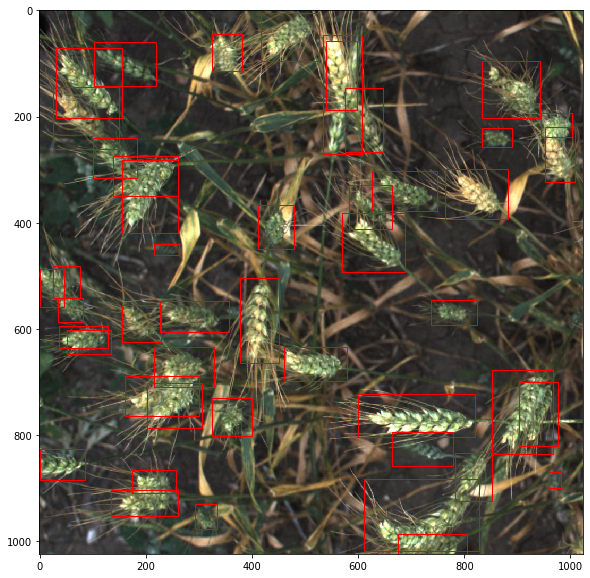

In [7]:
fig,ax = plt.subplots(figsize=(10,10))
plot_single_image(ax, *trn_dataset[0]);

### Exploring the `dataset`

In [8]:
len(trn_dataset)

3373

In [9]:
train_csv = pd.read_csv(os.path.join("/home/ubuntu/repos/kaggle/wheat/data", "fixed_train.csv"))
train_csv.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [10]:
train_csv.image_id.value_counts()

35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
b70c20580     97
            ... 
76595919e      1
4e6c05213      1
ce4124be0      1
47a1184e4      1
86296fc32      1
Name: image_id, Length: 3373, dtype: int64

In [11]:
train_csv.nunique()

image_id      3373
width            1
height           1
bbox        147752
source           7
dtype: int64

While the length of the train dataset is around 3422, we only have 3373 `image_id`s with bounding boxes. This implies that there are some images that have no bounding boxes.

In [12]:
#TODO: Write the dataset in a way that we can plot these images too.

## Initial `training`

In [13]:
import transforms as T
import utils
import torchvision
from engine import train_one_epoch, evaluate
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [14]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [16]:
# train dataset with Transforms
train_dataset = WheatDataset("/home/ubuntu/repos/kaggle/wheat/data", get_transform(train=True))

In [17]:
# train data loader
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

In [18]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
################################ Train Model ################################
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
dataset =  WheatDataset("/home/ubuntu/repos/kaggle/wheat/data", get_transform(train=True))
indices = torch.randperm(len(dataset)).tolist()
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
model = get_model()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

Epoch: [0]  [   0/1687]  eta: 0:31:30  lr: 0.000010  loss: 4.2559 (4.2559)  loss_classifier: 0.9438 (0.9438)  loss_box_reg: 0.3614 (0.3614)  loss_objectness: 2.7253 (2.7253)  loss_rpn_box_reg: 0.2254 (0.2254)  time: 1.1207  data: 0.4339  max mem: 1639
Epoch: [0]  [  10/1687]  eta: 0:13:49  lr: 0.000060  loss: 4.1184 (3.9579)  loss_classifier: 0.9119 (0.8913)  loss_box_reg: 0.3614 (0.3635)  loss_objectness: 2.5359 (2.4633)  loss_rpn_box_reg: 0.2448 (0.2398)  time: 0.4945  data: 0.0449  max mem: 2010
Epoch: [0]  [  20/1687]  eta: 0:12:55  lr: 0.000110  loss: 2.0900 (2.8564)  loss_classifier: 0.6923 (0.7565)  loss_box_reg: 0.4179 (0.3877)  loss_objectness: 0.7524 (1.4963)  loss_rpn_box_reg: 0.2303 (0.2159)  time: 0.4324  data: 0.0056  max mem: 2024
Epoch: [0]  [  30/1687]  eta: 0:12:35  lr: 0.000160  loss: 1.6325 (2.4376)  loss_classifier: 0.5520 (0.6839)  loss_box_reg: 0.4498 (0.4039)  loss_objectness: 0.4069 (1.1390)  loss_rpn_box_reg: 0.1890 (0.2108)  time: 0.4351  data: 0.0053  max me

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_first.pth')